# IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from scipy.stats import spearmanr
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report,confusion_matrix
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [2]:
#bacadata
df = pd.read_csv('loan_data_2007_2014.csv',index_col = 0)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.00,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.00,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.00,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.00,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.00,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Understanding

In [3]:
cols_to_drop = [
    # unique id
    'id'
    , 'member_id'
    
    # free text
    , 'url'
    , 'desc'
    
    # all null / constant / others
    , 'zip_code' 
    , 'annual_inc_joint'
    , 'dti_joint'
    , 'verification_status_joint'
    , 'open_acc_6m'
    , 'open_il_6m'
    , 'open_il_12m'
    , 'open_il_24m'
    , 'mths_since_rcnt_il'
    , 'total_bal_il'
    , 'il_util'
    , 'open_rv_12m'
    , 'open_rv_24m'
    , 'max_bal_bc'
    , 'all_util'
    , 'inq_fi'
    , 'total_cu_tl'
    , 'inq_last_12m'
    
    # expert judgment
    , 'sub_grade'
]

In [4]:
df = df.drop(cols_to_drop, axis=1)

In [5]:
df.shape

(466285, 51)

In [6]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,466285.00,466285.00,466285.00,466285.00,466285.00,466281.00,466285.00,466256.00,466256.00,215934.00,...,466285.00,466285.00,466285.00,466140.00,98974.00,466285.00,466256.00,396009.00,396009.00,396009.00
mean,14317.28,14291.80,14222.33,13.83,432.06,73277.38,17.22,0.28,0.80,34.10,...,85.34,8.96,3123.91,0.01,42.85,1.00,0.00,191.91,138801.71,30379.09
std,8286.51,8274.37,8297.64,4.36,243.49,54963.57,7.85,0.80,1.09,21.78,...,552.22,85.49,5554.74,0.11,21.66,0.00,0.07,14630.21,152114.66,37247.13
min,500.00,500.00,0.00,5.42,15.67,1896.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,8000.00,8000.00,8000.00,10.99,256.69,45000.00,11.36,0.00,0.00,16.00,...,0.00,0.00,312.62,0.00,26.00,1.00,0.00,0.00,28618.00,13500.00
50%,12000.00,12000.00,12000.00,13.66,379.89,63000.00,16.87,0.00,0.00,31.00,...,0.00,0.00,545.96,0.00,42.00,1.00,0.00,0.00,81539.00,22800.00
75%,20000.00,20000.00,19950.00,16.49,566.58,88960.00,22.78,0.00,1.00,49.00,...,0.00,0.00,3187.51,0.00,59.00,1.00,0.00,0.00,208953.00,37900.00
max,35000.00,35000.00,35000.00,26.06,1409.99,7500000.00,39.99,29.00,33.00,188.00,...,33520.27,7002.19,36234.44,20.00,188.00,1.00,5.00,9152545.00,8000078.00,9999999.00


In [7]:
df.isnull().sum().sort_values(ascending = False)

mths_since_last_record         403647
mths_since_last_major_derog    367311
mths_since_last_delinq         250351
next_pymnt_d                   227214
total_rev_hi_lim                70276
tot_cur_bal                     70276
tot_coll_amt                    70276
emp_title                       27588
emp_length                      21008
last_pymnt_d                      376
revol_util                        340
collections_12_mths_ex_med        145
last_credit_pull_d                 42
total_acc                          29
open_acc                           29
delinq_2yrs                        29
acc_now_delinq                     29
inq_last_6mths                     29
earliest_cr_line                   29
pub_rec                            29
title                              20
annual_inc                          4
dti                                 0
total_rec_late_fee                  0
funded_amnt_inv                     0
term                                0
int_rate    

In [8]:
# mendefinisikan nilai
good_loans = ['Current', 'Fully Paid', 'In Grace Period', 
              'Does not meet the credit policy. Status:Fully Paid']

# membuat kolom baru untuk klasifikasi akhir
df['good_bad_loan'] = np.where(df['loan_status'].isin(good_loans), 1, 0)

<Axes: title={'center': 'Good (1) vs Bad (0) Loans Balance'}>

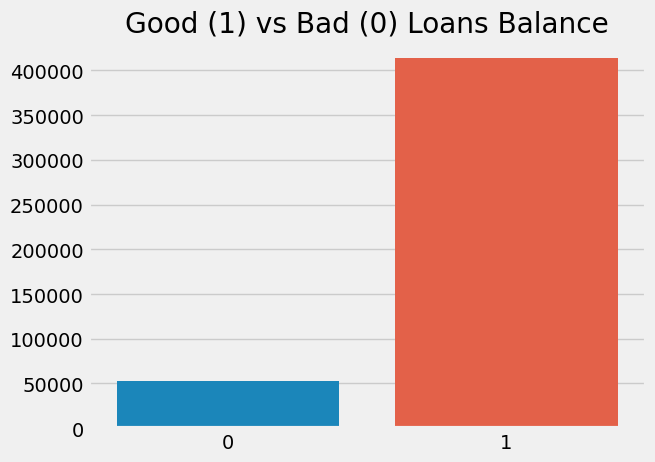

In [9]:
#membuat perbandingan antara good loan VS bad loan
plt.title('Good (1) vs Bad (0) Loans Balance')
sns.barplot(x=df.good_bad_loan.value_counts().index,y=df.good_bad_loan.value_counts().values)

# Feature Engineering

In [10]:
#Transformasi tipe Data
df_transform = ['term', 'emp_length', 'earliest_cr_line','last_credit_pull_d']
df[df_transform]

,term,emp_length,earliest_cr_line,last_credit_pull_d
0,36 months,10+ years,Jan-85,Jan-16
1,60 months,< 1 year,Apr-99,Sep-13
2,36 months,10+ years,Nov-01,Jan-16
3,36 months,10+ years,Feb-96,Jan-15
4,60 months,1 year,Jan-96,Jan-16
...,...,...,...,...
466280,60 months,4 years,Apr-03,Jan-16
466281,60 months,10+ years,Jun-97,Jan-16
466282,60 months,7 years,Dec-01,Dec-15
466283,36 months,3 years,Feb-03,Apr-15


In [11]:
#1.Konversikan kolom TERM ke tipe data numerik dan menghapus kata (months)
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))
df['term']

0         36
1         60
2         36
3         36
4         60
          ..
466280    60
466281    60
466282    60
466283    36
466284    36
Name: term, Length: 466285, dtype: int64

In [12]:
#2.Konversikan kolom emp_length ke tipe data numerik dan menghapus kata (years)
emp_map = {
    '< 1 year' : '0',
    '1 year' : '1',
    '2 years' : '2',
    '3 years' : '3',
    '4 years' : '4',
    '5 years' : '5',
    '6 years' : '6',
    '7 years' : '7',
    '8 years' : '8',
    '9 years' : '9',
    '10+ years' : '10'
}

df['emp_length'] = df['emp_length'].map(emp_map).fillna('0').astype(int)
df['emp_length'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7])

In [13]:
#3 menyeragamkan kolom earliest_cr_line
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [14]:
# Asumsi sekarang  akhir bulan December 2014
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2014-12-31') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
df['mths_since_earliest_cr_line'].describe()

count   466256.00
mean       204.48
std         93.97
min       -647.00
25%        148.00
50%        190.00
75%        250.00
max        552.00
Name: mths_since_earliest_cr_line, dtype: float64

In [15]:
# tampilkan baris di mana variabel memiliki nilai negatif
df.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-572.00
1770,Sep-68,2068-09-01,-644.00
2799,Sep-64,2064-09-01,-596.00
3282,Sep-67,2067-09-01,-632.00
3359,Feb-65,2065-02-01,-601.00
...,...,...,...
464003,Jan-68,2068-01-01,-636.00
464260,Jul-66,2066-07-01,-618.00
465100,Oct-67,2067-10-01,-633.00
465500,Sep-67,2067-09-01,-632.00


In [16]:
df['earliest_cr_line_date'] = df['earliest_cr_line_date'].astype(str)
df['earliest_cr_line_date'][df['mths_since_earliest_cr_line'] < 0] = df['earliest_cr_line_date'][df['mths_since_earliest_cr_line'] < 0].str.replace('20','19')

In [17]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line_date'])
df['earliest_cr_line_date']

0        1985-01-01
1        1999-04-01
2        2001-11-01
3        1996-02-01
4        1996-01-01
            ...    
466280   2003-04-01
466281   1997-06-01
466282   2001-12-01
466283   2003-02-01
466284   2000-02-01
Name: earliest_cr_line_date, Length: 466285, dtype: datetime64[ns]

In [18]:
#hapus kolom earliest_cr_line_date, mths_since_earliest_cr_line dan earliest_cr_line karena tidak digunakan lagi
df.drop(columns = ['earliest_cr_line_date' ,'mths_since_earliest_cr_line', 
                          'earliest_cr_line'], inplace = True)

In [19]:
#4 menyeragamkan kolom last credit pull d untuk menjadi numerik 
df['last_credit_pull_d']

0         Jan-16
1         Sep-13
2         Jan-16
3         Jan-15
4         Jan-16
           ...  
466280    Jan-16
466281    Jan-16
466282    Dec-15
466283    Apr-15
466284    Jan-16
Name: last_credit_pull_d, Length: 466285, dtype: object

In [20]:
# Asumsikan sekarang  akhir bulan desember / awal bulan januari
# Extracts the date and the time from a string variable that is in a given format. and fill NaN data with max date
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format = '%b-%y').fillna(pd.to_datetime("2015-01-01"))

# hitung selisih antara dua tanggal dalam bulan, ubah menjadi tipe data numerik dan bulatkan
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2018-12-31') - df['last_credit_pull_d']) / np.timedelta64(1, 'M')))

# Menampilkan deskripsi statistik dari kolom tersebut
df['mths_since_last_credit_pull_d'].describe()

count   466285.00
mean        40.05
std          9.64
min         36.00
25%         36.00
50%         36.00
75%         38.00
max        140.00
Name: mths_since_last_credit_pull_d, dtype: float64

In [21]:
# Menghapus kolom last_credit_pull_d karena tidak terpakai lagi
df.drop(columns = ['last_credit_pull_d'], inplace = True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      466285 non-null  int64  
 1   funded_amnt                    466285 non-null  int64  
 2   funded_amnt_inv                466285 non-null  float64
 3   term                           466285 non-null  int64  
 4   int_rate                       466285 non-null  float64
 5   installment                    466285 non-null  float64
 6   grade                          466285 non-null  object 
 7   emp_title                      438697 non-null  object 
 8   emp_length                     466285 non-null  int32  
 9   home_ownership                 466285 non-null  object 
 10  annual_inc                     466281 non-null  float64
 11  verification_status            466285 non-null  object 
 12  issue_d                       

In [23]:
df.select_dtypes(include='object').nunique()

grade                       7
emp_title              205475
home_ownership              6
verification_status         3
issue_d                    91
loan_status                 9
pymnt_plan                  2
purpose                    14
title                   63099
addr_state                 50
initial_list_status         2
last_pymnt_d               98
next_pymnt_d              100
application_type            1
dtype: int64

In [24]:
df.drop(['emp_title', 'title', 'application_type'], axis=1, inplace=True)

In [25]:
df.select_dtypes(exclude='object').nunique()

loan_amnt                          1352
funded_amnt                        1354
funded_amnt_inv                    9854
term                                  2
int_rate                            506
installment                       55622
emp_length                           11
annual_inc                        31901
dti                                3997
delinq_2yrs                          24
inq_last_6mths                       28
mths_since_last_delinq              145
mths_since_last_record              123
open_acc                             62
pub_rec                              26
revol_bal                         58142
revol_util                         1269
total_acc                           112
out_prncp                        135665
out_prncp_inv                    141189
total_pymnt                      351609
total_pymnt_inv                  347659
total_rec_prncp                  172713
total_rec_int                    270249
total_rec_late_fee                 5808


In [26]:
df.drop(['policy_code'], axis=1, inplace=True)

In [27]:
for col in df.select_dtypes(include='object').columns.tolist():
    print(df[col].value_counts(normalize=True)*100)
    print('\n')

B   29.37
C   26.87
D   16.49
A   16.06
E    7.67
F    2.84
G    0.71
Name: grade, dtype: float64


MORTGAGE   50.59
RENT       40.42
OWN         8.94
OTHER       0.04
NONE        0.01
ANY         0.00
Name: home_ownership, dtype: float64


Verified          36.04
Source Verified   32.17
Not Verified      31.79
Name: verification_status, dtype: float64


Oct-14   8.32
Jul-14   6.28
Nov-14   5.37
May-14   4.10
Apr-14   4.09
         ... 
Aug-07   0.02
Jul-07   0.01
Sep-08   0.01
Sep-07   0.01
Jun-07   0.01
Name: issue_d, Length: 91, dtype: float64


Current                                               48.09
Fully Paid                                            39.62
Charged Off                                            9.11
Late (31-120 days)                                     1.48
In Grace Period                                        0.67
Does not meet the credit policy. Status:Fully Paid     0.43
Late (16-30 days)                                      0.26
Default                  

In [28]:
df.drop('pymnt_plan', axis=1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      466285 non-null  int64  
 1   funded_amnt                    466285 non-null  int64  
 2   funded_amnt_inv                466285 non-null  float64
 3   term                           466285 non-null  int64  
 4   int_rate                       466285 non-null  float64
 5   installment                    466285 non-null  float64
 6   grade                          466285 non-null  object 
 7   emp_length                     466285 non-null  int32  
 8   home_ownership                 466285 non-null  object 
 9   annual_inc                     466281 non-null  float64
 10  verification_status            466285 non-null  object 
 11  issue_d                        466285 non-null  object 
 12  loan_status                   

In [30]:
df.drop(['loan_status','mths_since_last_record'],axis=1,inplace=True)

# train test split

In [31]:
# memisahkan variabel target (y) dan prediktor (X)
X = df.drop('good_bad_loan',axis =1)
y = df['good_bad_loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [32]:
from sklearn.preprocessing import LabelEncoder

# List of columns to be transformed
columns_to_transform = ['grade', 'verification_status', 'issue_d', 'purpose', 'addr_state',
                        'initial_list_status', 'last_pymnt_d', 'next_pymnt_d','home_ownership']

# Create a LabelEncoder object
le = LabelEncoder()

# Loop through each column and apply label encoding for X_train
for col in columns_to_transform:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])


In [33]:
for col in columns_to_transform:
    le.fit(X_test[col])
    X_test[col] = le.transform(X_test[col])

In [34]:
check_missing = X_train.isnull().sum() * 100 / X_train.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_major_derog   78.77
mths_since_last_delinq        53.69
tot_coll_amt                  15.07
tot_cur_bal                   15.07
total_rev_hi_lim              15.07
revol_util                     0.08
collections_12_mths_ex_med     0.03
delinq_2yrs                    0.01
inq_last_6mths                 0.01
open_acc                       0.01
pub_rec                        0.01
total_acc                      0.01
acc_now_delinq                 0.01
annual_inc                     0.00
dtype: float64

In [35]:
X_train.drop(['mths_since_last_major_derog','mths_since_last_delinq'],axis=1,inplace=True)

In [36]:
X_test.drop(['mths_since_last_major_derog','mths_since_last_delinq'],axis=1,inplace=True)

In [37]:
X_train.isnull().sum()

loan_amnt                            0
funded_amnt                          0
funded_amnt_inv                      0
term                                 0
int_rate                             0
installment                          0
grade                                0
emp_length                           0
home_ownership                       0
annual_inc                           3
verification_status                  0
issue_d                              0
purpose                              0
addr_state                           0
dti                                  0
delinq_2yrs                         26
inq_last_6mths                      26
open_acc                            26
pub_rec                             26
revol_bal                            0
revol_util                         287
total_acc                           26
initial_list_status                  0
out_prncp                            0
out_prncp_inv                        0
total_pymnt              

In [38]:
# Misalkan 'X_train' adalah DataFrame yang berisi data training Anda
# Misalkan data training memiliki kolom-kolom berikut
columns_to_fillna = ['annual_inc', 'acc_now_delinq', 'total_acc', 'pub_rec', 'open_acc',
                     'inq_last_6mths', 'delinq_2yrs', 'collections_12_mths_ex_med',
                     'revol_util', 'tot_cur_bal', 'tot_coll_amt','total_rev_hi_lim']

# Mengisi nilai yang hilang dengan nilai rata-rata (mean) dari masing-masing kolom
for col in columns_to_fillna:
    X_train[col].fillna(X_train[col].mean(), inplace=True)


In [39]:
for col in columns_to_fillna:
    X_test[col].fillna(X_test[col].mean(), inplace=True)

In [40]:
X_train.shape

(373028, 41)

In [41]:
# Hapus nilai infinit
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Ganti nilai infinit dengan median
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True)

In [42]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [43]:
X_train.shape

(662558, 41)

In [44]:
X_test.shape

(93257, 41)

In [45]:
# Scaling dengan RobustScaler
rs = RobustScaler()
X_train_transformed = rs.fit_transform(X_train)
X_test_transformed = rs.transform(X_test)

# Feature Selection

<Axes: >

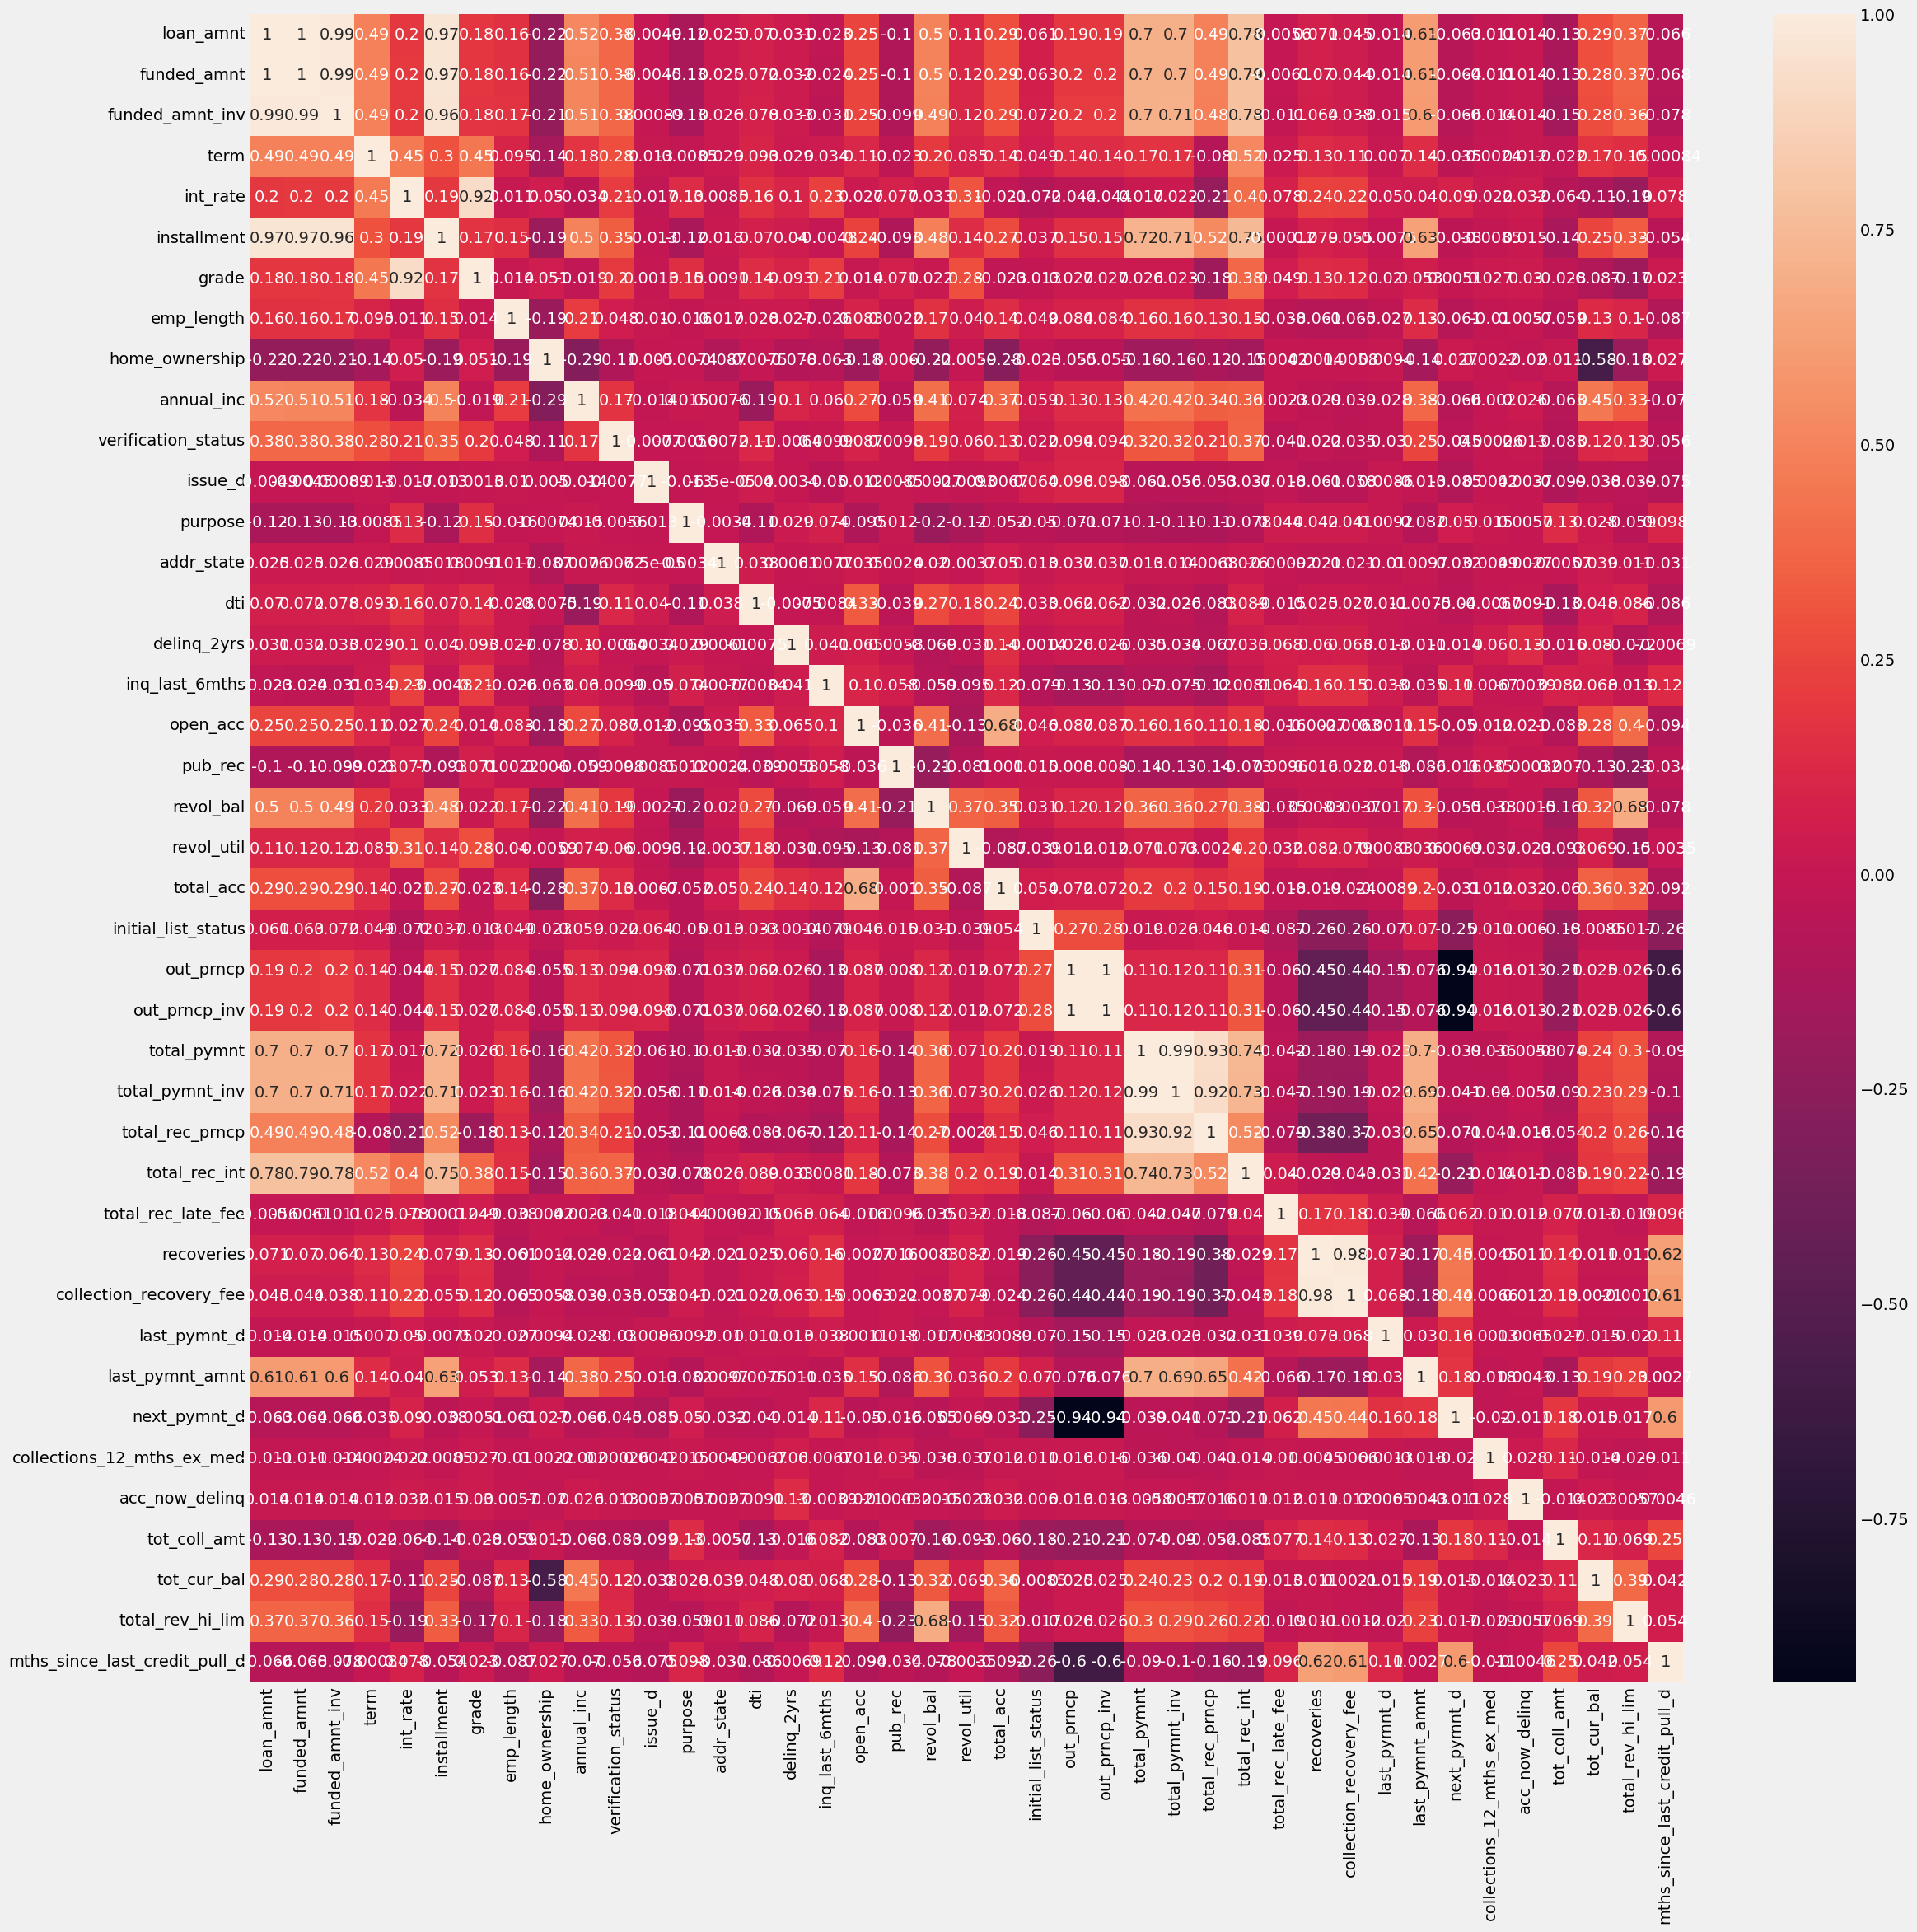

In [46]:
X_train_transformed_df = pd.DataFrame(data=X_train_transformed, columns=X_train.columns)
corr = X_train_transformed_df.corr(method = 'spearman')
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)

In [47]:
var = []
drop = []
for x in X_train_transformed_df.columns:
  for y in X_train_transformed_df.columns:
    if x != y:
      if [y,x] not in var:
        corr, p_value = spearmanr(X_train_transformed_df[x], X_train_transformed_df[y])
        var.append([x, y])
        if (corr <= -0.8) | (corr >= 0.8):
          if p_value < 0.05:
            drop.append(y)

In [48]:
drop

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'funded_amnt_inv',
 'installment',
 'installment',
 'grade',
 'out_prncp_inv',
 'next_pymnt_d',
 'next_pymnt_d',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_prncp',
 'collection_recovery_fee']

In [49]:
X_train_transformed_df = X_train_transformed_df.drop(drop, axis=1)

In [50]:
X_train_transformed_df.shape

(662558, 32)

In [51]:
mutual_info_classif(X_train_transformed_df,
                    y_train,
                    random_state = 123)

array([0.37630117, 0.09800498, 0.48883414, 0.04415673, 0.07125791,
       0.26913897, 0.01633898, 0.16402575, 0.0451319 , 0.09662844,
       0.46858315, 0.11798726, 0.28466413, 0.42642605, 0.08380551,
       0.00105296, 0.48608153, 0.46593158, 0.03930525, 0.10266419,
       0.15082807, 0.06614114, 0.04953132, 0.29755375, 0.29944061,
       0.29846733, 0.00601185, 0.00201552, 0.0735303 , 0.02806376,
       0.35134115, 0.27670371])

In [52]:
mutual_table = pd.DataFrame(mutual_info_classif(X_train_transformed_df,y_train,random_state = 123),
                            index = X_train_transformed_df.columns,
                            columns = ['mutual_info']).sort_values('mutual_info', ascending = False)

In [53]:
mutual_table

,mutual_info
int_rate,0.49
revol_util,0.49
dti,0.47
total_acc,0.47
open_acc,0.43
loan_amnt,0.38
total_rev_hi_lim,0.35
last_pymnt_d,0.30
last_pymnt_amnt,0.30
recoveries,0.30


In [54]:
X_train_mt = mutual_table.iloc[0:19].index

In [55]:
X_train = X_train_transformed_df.loc[:, X_train_mt]

In [56]:
X_train.shape

(662558, 19)

In [57]:
X_test_transformed.shape

(93257, 41)

In [58]:
X_test_transformed_df = pd.DataFrame(data=X_test_transformed, columns=X_test.columns)

In [59]:
X_test = X_test_transformed_df.loc[:,list(X_train.columns)]

In [60]:
X_test.shape

(93257, 19)

In [61]:
y_train.value_counts()

1    331279
0    331279
Name: good_bad_loan, dtype: int64

In [62]:
rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rfc.predict(X_test)

In [63]:
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77     10437
           1       0.98      0.96      0.97     82820

    accuracy                           0.95     93257
   macro avg       0.85      0.90      0.87     93257
weighted avg       0.95      0.95      0.95     93257



In [64]:
rfc.score(X_train,y_train),rfc.score(X_test,y_test)

(0.9421258214375194, 0.9454839851163988)

In [65]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

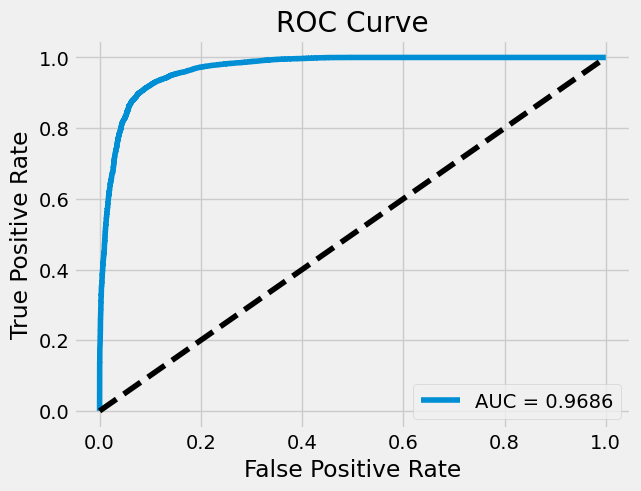

In [66]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

In [67]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())

In [68]:
df_actual_predicted.head()

,index,y_actual,y_pred_proba,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,53886,0,0.03,1,0,1,0.00,0.00,0.00
1,204437,0,0.03,2,0,2,0.00,0.00,0.00
2,376169,0,0.03,3,0,3,0.00,0.00,0.00
3,407541,0,0.03,4,0,4,0.00,0.00,0.00
4,418221,0,0.03,5,0,5,0.00,0.00,0.00


Text(0.5, 1.0, 'Kolmogorov-Smirnov:  0.8225')

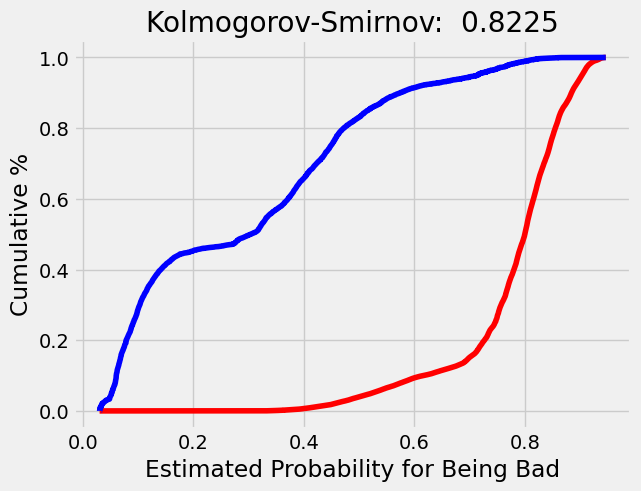

In [69]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)